<a href="https://colab.research.google.com/github/lala991204/DL-self-study/blob/master/tensorflow/4_3_eurosat_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model

# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

In [ ]:
# EuroSAT 위성 사진 데이터셋 로드
DATA_DIR = "dataset/"             # 저장 위치
(train_ds, valid_ds), info = tfds.load('eurosat/rgb',
                                       split=['train[:80%]', 'train[80%:]'],   # train set만 제공하므로 이를 train,valid set으로 나눔
                                       shuffle_files=True,
                                       as_supervised=True,
                                       with_info=True,             # meta infomation 불러오기
                                       data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to dataset/eurosat/rgb/2.0.0.incomplete36K6AE/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_OptionsDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
# 메타 데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

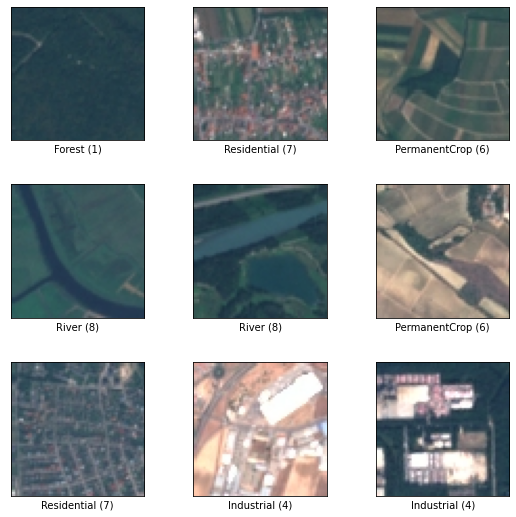

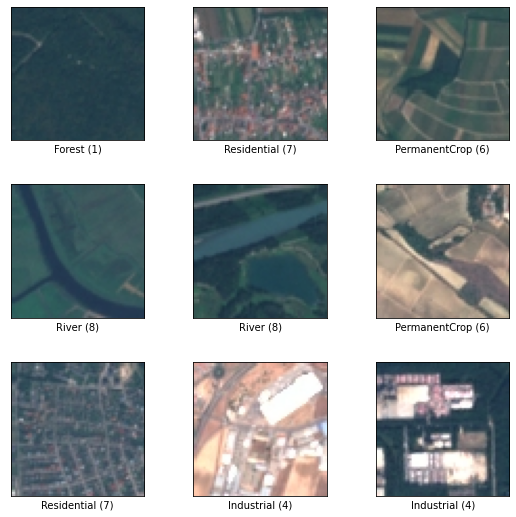

In [ ]:
# 데이터 확인(sample image를 메타 정보인 분류 label과 함께 출력)
tfds.show_examples(train_ds, info)

,image,label
0,,9 (SeaLake)
1,,8 (River)
2,,9 (SeaLake)
3,,9 (SeaLake)
4,,9 (SeaLake)
5,,0 (AnnualCrop)
6,,2 (HerbaceousVegetation)
7,,0 (AnnualCrop)
8,,0 (AnnualCrop)
9,,2 (HerbaceousVegetation)

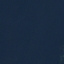
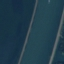
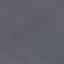
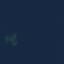
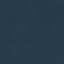
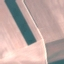
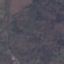
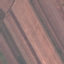
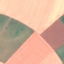
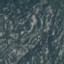

In [ ]:
# as_dataframe 이용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [ ]:
# 목표 클래스 개수(=> 토지이용분류에 해당하는 정답 class 개수)
NUM_CLASSES = info.features['label'].num_classes
print(NUM_CLASSES)

# 숫자 레이블을 활용해 문자열 메타 데이터로 변환
print(info.features['label'].int2str(6))

10
PermanentCrop


# 데이터 전처리

prefetch() 메소드는 model이 훈련을 진행하는 동안 다음에 입력할 데이터를 불러와 미리 전처리를 하도록 시스템을 조율함. 병렬 처리를 통해 model 훈련 시간을 단축시켜줌.

참고로, Buffer는 데이터를 한 곳에서 다른 한 곳으로 전송하는 동안 일시적으로 그 데이터를 보관하는 메모리의 영역이다.

In [ ]:
# 데이터 전처리 파이프라인
BATCH_SIZE = 64
BUFFER_SIZE = 1000    

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.0          # 0~1 정규화, float32 변환(tensorflow 연산은 float32 숫자 값 사용)
    return image, label

# tensorflow 병렬연산 처리를 자동으로 최적화 옵션도 적용(훨씬 짧은 시간 처리 가능)
train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

# 처음 1000개 데이터 가져와 섞고, 여기서 64개의 데이터를 랜덤하게 선택하여 하나의 (미니)배치 구성 => 다시 buffer에 추가되어 항상 1000개의 buffer 구성...
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# 검증 datasets은 평가 목적에 활용되기 때문에 shuffle 하지 않음(순서 중요 X)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

# 모델 훈련 및 검증

In [ ]:
# Sequential API 사용하여 sample model 생성
def build_model():
    model = tf.keras.Sequential([
            # Convolution 층
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2,2)),
            
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2,2)),

            # Classifier 출력층
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

model = build_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_data,
                    validation_data = valid_data,
                    epochs=50)

Epoch 1/50
338/338 [==============================] - 165s 483ms/step - loss: 1.5798 - accuracy: 0.4555 - val_loss: 1.5378 - val_accuracy: 0.5220
Epoch 2/50
338/338 [==============================] - 176s 521ms/step - loss: 1.2190 - accuracy: 0.5752 - val_loss: 0.8697 - val_accuracy: 0.7281
Epoch 3/50
338/338 [==============================] - 213s 630ms/step - loss: 1.0145 - accuracy: 0.6400 - val_loss: 0.7683 - val_accuracy: 0.7537
Epoch 4/50
338/338 [==============================] - 233s 689ms/step - loss: 0.9193 - accuracy: 0.6755 - val_loss: 0.6636 - val_accuracy: 0.7869
Epoch 5/50
338/338 [==============================] - 231s 683ms/step - loss: 0.8323 - accuracy: 0.7057 - val_loss: 0.6051 - val_accuracy: 0.8004
Epoch 6/50
338/338 [==============================] - 230s 679ms/step - loss: 0.7587 - accuracy: 0.7340 - val_loss: 0.5345 - val_accuracy: 0.8348
Epoch 7/50
338/338 [==============================] - 229s 675ms/step - loss: 0.6984 - accuracy: 0.7573 - val_loss: 0.5229 -

In [ ]:
def plot_loss_acc(history, epoch):
    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

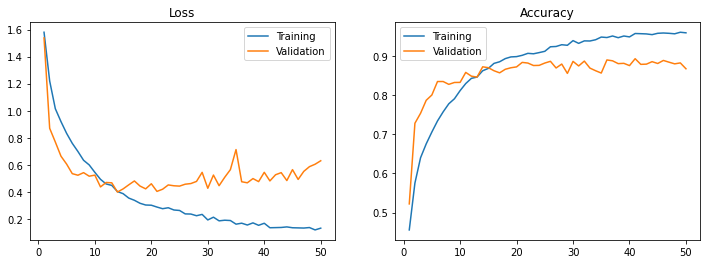

In [ ]:
plot_loss_acc(history, 50)

10 epochs 이후로 검증 셋에 대한 loss가 더 이상 줄어들지 않으면서 과대적합 경향을 나타냄

# 데이터 증강(Data Augmentation)

앞서 배치 정규화, Dropout 등을 적용했음에도 과대적합이 발생하였다. 이미지 분류 문제에서 과대적합을 해소하는 동시에 모델의 일반화된 Robust한 성능을 확보하는 기법으로 데이터 증강(Data Augmentation) 기법에 대해 알아보자.

image data에 여러 가지 변형을 주어 훈련 데이터의 다양성을 확보하는 방식으로, model이 새로운 데이터에 대한 예측력을 강화하도록 하는 개념이다.

Text(0.5, 1.0, 'Residential')

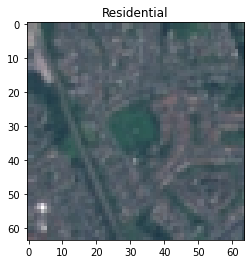

In [ ]:
# sample image
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label))

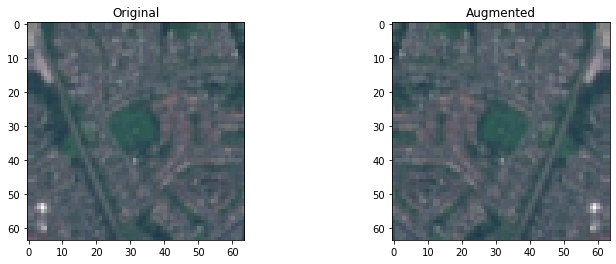

In [ ]:
# 데이터 증강 전후를 비교하는 시각화 함수 정의
def plot_augmentation(original, augmented):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].imshow(original)
    axes[0].set_title('Original')
    
    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

# 좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

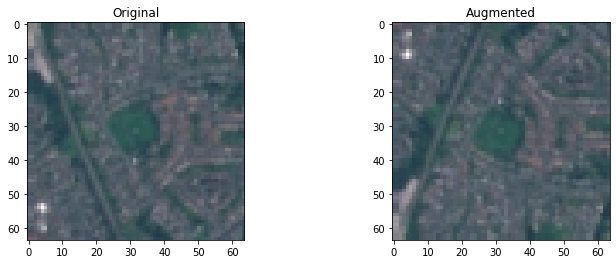

In [ ]:
# 상하 뒤집기
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

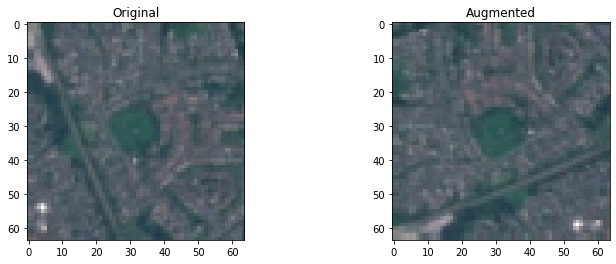

In [ ]:
# 회전(반시계 90도)
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

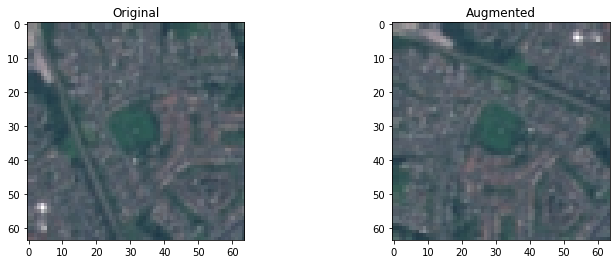

In [ ]:
# transpose(이미지 텐서 행렬의 도치)
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

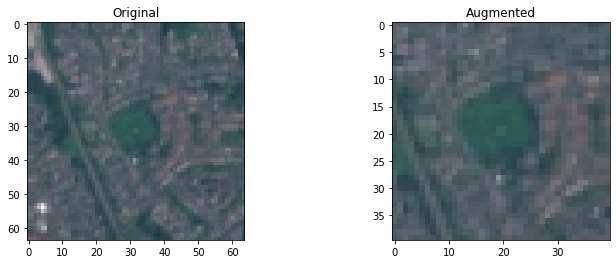

In [ ]:
# image cut1 (이미지 중심에서 일정 부분 잘라내기)
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

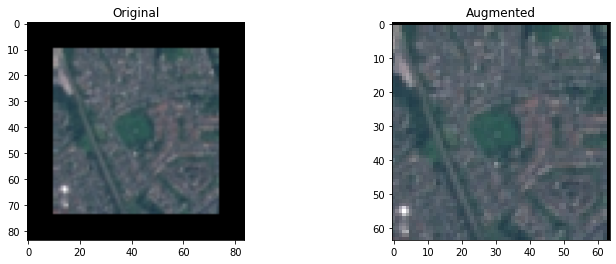

In [ ]:
# image_cut2
image = tf.image.resize_with_crop_or_pad(image, 64 +20, 64 +20)     # size 키우기
crop2 = tf.image.random_crop(image, size=[64, 64, 3])         # 원본 크기와 같게 자름(=>상하좌우 랜덤 방향으로 shift 이동)
plot_augmentation(image, crop2)

In [ ]:
# 이미지 밝기
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

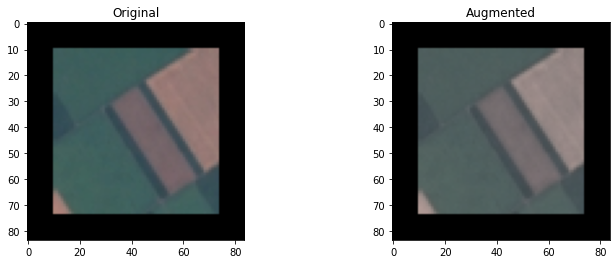

In [ ]:
# 이미지 채도
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

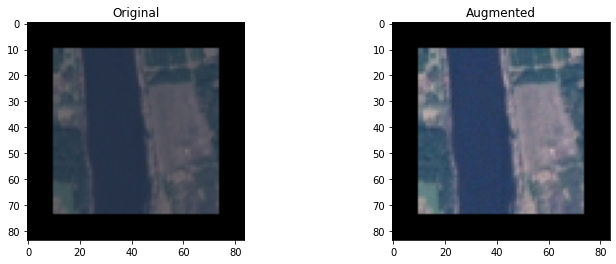

In [ ]:
# 이미지 대비(contrast)
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [ ]:
# 이미지 증강 전처리(random성 부여)
def data_augmentation(image, label):
    image = tf.image.random_flip_left_right(image)     # 좌우 반전
    image = tf.image.random_flip_up_down(image)        # 상하 반전
    image = tf.image.random_brightness(image, max_delta=0.3)     # 밝기 변화
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255.0       # 0~1 정규화

    return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls = tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls = tf.data.AUTOTUNE)

# 미니 배치
train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

# 모델 생성
aug_model = build_model()
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
aug_history = aug_model.fit(train_aug,
                            validation_data = valid_aug,
                            epochs=50)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Epoch 1/50
338/338 [==============================] - 162s 473ms/step - loss: 1.9197 - accuracy: 0.2725 - val_loss: 1.8225 - val_accuracy: 0.3759
Epoch 2/50
338/338 [==============================] - 155s 459ms/step - loss: 1.6051 - accuracy: 0.3737 - val_loss: 1.4044 - val_accuracy: 0.5237
Epoch 3/50
338/338 [==============================] - 155s 459ms/step - loss: 1.4886 - accuracy: 0.4238 - val_loss: 1.2684 - val_accuracy: 0.5385
Epoch 4/50
338/338 [==============================] - 157s 465ms/step - loss: 1.3849 - accuracy: 0.4719 - val_loss: 1.2217 - val_accuracy: 0.5726
Epoch 5/50
338/338 [==============================] - 155s 457ms/step - loss: 1.3134 - accuracy: 0.5049 - val_lo

데이터 증강 전과 모델 성능 자체에 큰 차이는 없으나, 50 epoch동안 loss, accuracy가 조금씩 우상향되는 것을 보아 과대적합 문제가 상당히 해소되었다는 것을 확인 가능.

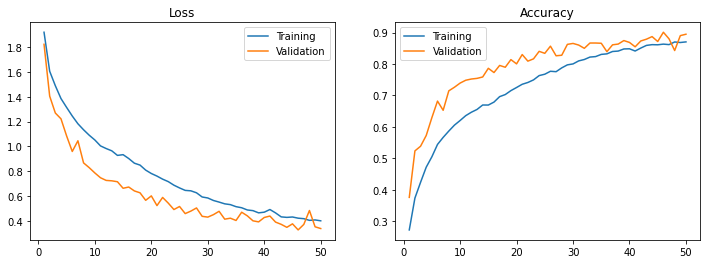

In [ ]:
plot_loss_acc(aug_history, 50)

But, 검증 셋에 대한 loss가 훈련 셋에 대한 loss보다 여전히 더 낮음. 고로, epoch 수를 더 늘려 성능 개선시킬 여지가 있음.

# ResNet 사전 학습 모델

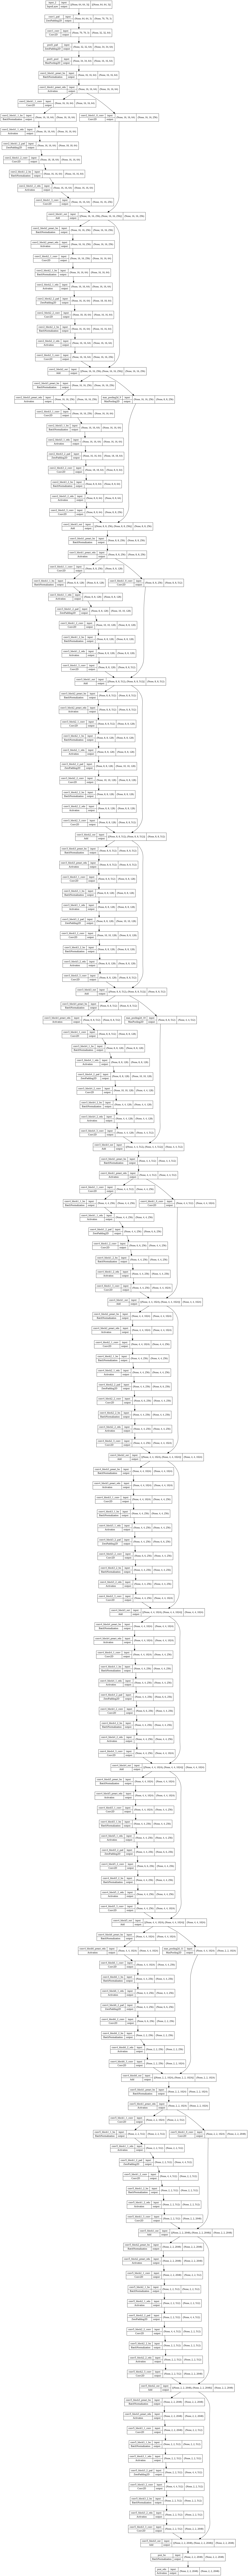

In [ ]:
pre_trained_base = ResNet50V2(include_top=False,          # 기존 ResNet 모델의 top층을 제거하고 최종 분류기를 대체 할 것임.(중요!)
                              weights='imagenet',
                              input_shape=[64, 64, 3])    # 위성 이미지 크기로 맞춰줌.

# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

In [ ]:
# Top 층에 Classifier 추가 (=> Transfer Learning)
def build_trainsfer_classifier():
    model = tf.keras.Sequential([
            # Pre-trained Base
            pre_trained_base,
            # Classifier 출력층
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

# 모델 구조
tc_model = build_trainsfer_classifier()
tc_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 10)               

우리가 Top 층에 추가한 Dense layer들의 파라미터만 가중치 업데이트됨.

In [ ]:
tc_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
tc_history = tc_model.fit(train_aug,
                          validation_data = valid_aug,
                          epochs=50)

Epoch 1/50
338/338 [==============================] - 292s 848ms/step - loss: 1.0406 - accuracy: 0.6642 - val_loss: 0.6102 - val_accuracy: 0.7991
Epoch 2/50
338/338 [==============================] - 272s 805ms/step - loss: 0.7339 - accuracy: 0.7648 - val_loss: 0.5349 - val_accuracy: 0.8204
Epoch 3/50
338/338 [==============================] - 273s 806ms/step - loss: 0.6616 - accuracy: 0.7906 - val_loss: 0.5031 - val_accuracy: 0.8306
Epoch 4/50
338/338 [==============================] - 273s 807ms/step - loss: 0.6036 - accuracy: 0.8115 - val_loss: 0.4764 - val_accuracy: 0.8404
Epoch 5/50
338/338 [==============================] - 272s 805ms/step - loss: 0.5687 - accuracy: 0.8190 - val_loss: 0.4588 - val_accuracy: 0.8444
Epoch 6/50
338/338 [==============================] - 272s 804ms/step - loss: 0.5429 - accuracy: 0.8259 - val_loss: 0.4509 - val_accuracy: 0.8470
Epoch 7/50
338/338 [==============================] - 273s 806ms/step - loss: 0.5247 - accuracy: 0.8319 - val_loss: 0.4417 -

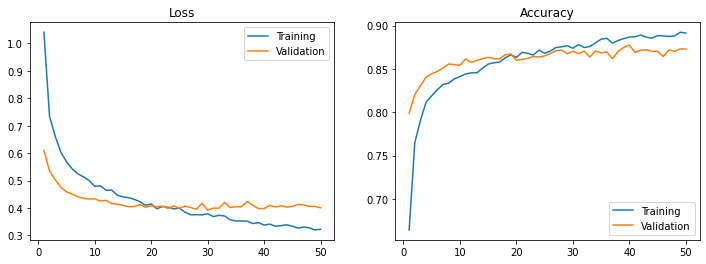

In [ ]:
plot_loss_acc(tc_history, 50)

훈련 초부터 검증 셋에 대한 accuracy가 80%를 넘어선다. 즉, 사전 학습 모델의 가중치를 그대로 사용하므로 새로운 데이터가 입력되어도 image로부터 피처(특징)를 빠르게 추출하는 것을 볼 수 있다.